In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
import requests
import torch
from PIL import Image
from io import BytesIO
from tqdm.notebook import tqdm
from transformers import AutoProcessor, AutoModelForVision2Seq
from transformers.image_utils import load_image
from transformers import AutoModelForCausalLM 
import pandas as pd
from torchvision import transforms
import matplotlib.pyplot as plt
import json
DEVICE = "cuda:0"


In [3]:
train_images="train_images"
train=pd.read_csv('train.csv')
train.head()

,id,Category,len,attr_1,attr_2,attr_3,attr_4,attr_5,attr_6,attr_7,attr_8,attr_9,attr_10
0,0,Men Tshirts,5,default,round,printed,default,short sleeves,NaN,NaN,NaN,NaN,NaN
1,1,Men Tshirts,5,multicolor,polo,solid,solid,short sleeves,NaN,NaN,NaN,NaN,NaN
2,2,Men Tshirts,5,default,polo,solid,solid,short sleeves,NaN,NaN,NaN,NaN,NaN
3,3,Men Tshirts,5,multicolor,polo,solid,solid,short sleeves,NaN,NaN,NaN,NaN,NaN
4,4,Men Tshirts,5,multicolor,polo,solid,solid,short sleeves,NaN,NaN,NaN,NaN,NaN


In [4]:
with open("categories.json","r") as f:
    categories = json.load(f)

In [5]:
model_id = "microsoft/Phi-3.5-vision-instruct" 
# Note: set _attn_implementation='eager' if you don't have flash_attn installed
model = AutoModelForCausalLM.from_pretrained(
  model_id, 
  device_map="cuda", 
  trust_remote_code=True, 
  torch_dtype="auto",
  load_in_4bit=True, 
  _attn_implementation='flash_attention_2'    
)
# for best performance, use num_crops=4 for multi-frame, num_crops=16 for single-frame.
processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True, num_crops=4) 

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/aseems/.local/lib/python3.8/site-packages/transformers/models/auto/image_processing_auto.py:517: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


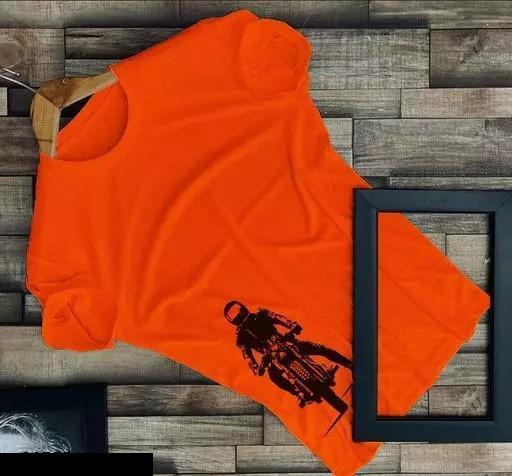

In [6]:
id=0
image = Image.open(os.path.join(train_images, f"{train['id'][id]:06d}"+'.jpg'))
display(image)

In [7]:
images = [image]
placeholder = "<|image_1|>\n"

# Note: if OOM, you might consider reduce number of frames in this example.

messages = [
    {"role": "user", "content": placeholder+f"Answer the following details about the image: {categories[train['Category'][id]]}"},
]

prompt = processor.tokenizer.apply_chat_template(
  messages, 
  tokenize=False, 
  add_generation_prompt=True
)

inputs = processor(prompt, images, return_tensors="pt").to("cuda:0") 

generation_args = { 
    "max_new_tokens": 100, 
    "temperature": 0.4, 
    "do_sample": False, 
} 

generate_ids = model.generate(**inputs, 
  eos_token_id=processor.tokenizer.eos_token_id, 
  **generation_args
)

# remove input tokens 
generate_ids = generate_ids[:, inputs['input_ids'].shape[1]:]
response = processor.batch_decode(generate_ids, 
  skip_special_tokens=True, 
  clean_up_tokenization_spaces=False)[0] 

print(response)


/home/aseems/.local/lib/python3.8/site-packages/transformers/generation/configuration_utils.py:601: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.4` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.


- Color: Orange
- Neck: Crew neck
- Pattern: Solid color with a graphic print
- Print or Pattern Type: Graphic print of a soldier with a rifle
- Sleeve Length: Short sleeves


In [8]:
import sys
class customDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data=data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data.iloc[idx]

def collate_fn(examples):
    d={'input_ids':[],'attention_mask':[],'pixel_values':[],'id':[],'image_sizes':[]}
    for example in examples:
        id=example['id']
        image = Image.open(os.path.join(train_images, f"{train['id'][id]:06d}"+'.jpg'))
        placeholder = "<|image_1|>\n"

        # Note: if OOM, you might consider reduce number of frames in this example.

        messages = [
            {"role": "user", "content": placeholder+f"Answer the following details about the image: {categories[train['Category'][id]]}"},
        ]
        prompt = processor.tokenizer.apply_chat_template(
            messages, 
            tokenize=False, 
            add_generation_prompt=True
        )
        batch = processor(prompt, [image], return_tensors="pt",padding=True)
        d['input_ids'].append(batch['input_ids'])
        d['attention_mask'].append(batch['attention_mask'])
        d['pixel_values'].append(batch['pixel_values'])
        d['image_sizes'].append(batch['image_sizes'])
        d['id'].append(id)
    for i in d:
        if i!='id':
            d[i]=torch.cat(d[i],dim=0).to(DEVICE)
        # print(d[i].shape)
    return d


In [9]:
train_dataloader = torch.utils.data.DataLoader(customDataset(train[0:10]), batch_size=4, shuffle=False,collate_fn=collate_fn)

  0%|          | 0/3 [00:00<?, ?it/s]

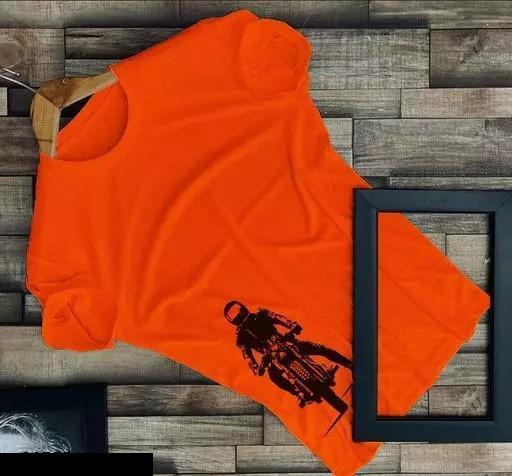

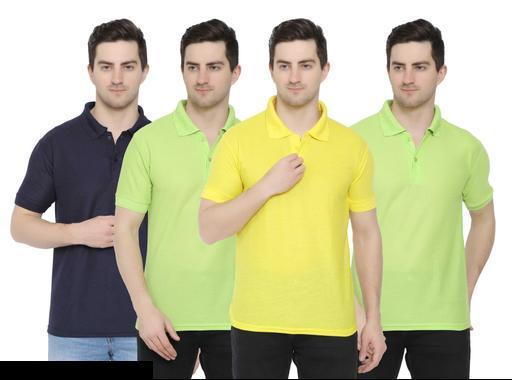

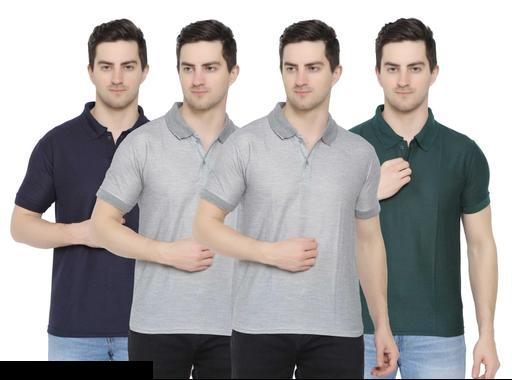

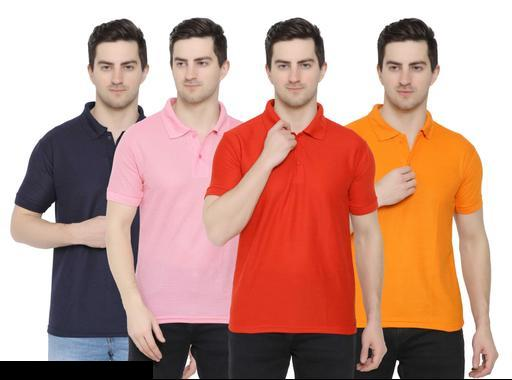

4
- Color: Orange
- Neck: Scoop neck
- Pattern/Print Type: Solid color with a graphic print
- Sleeve Length: Short sleeves

- The colors of the shirts are navy blue, yellow, and lime green.
- The neck design is a standard pointed collar.
- There is no visible pattern or print on the shirts; they appear to be solid colors.
- The sleeve length is short, typical of a polo shirt.

- The colors of the shirts are navy blue, grey, light grey, and dark green.
- The neckprint or pattern type is a standard collar.
- The sleeve length is short.

- The colors of the shirts are navy blue, pink, red, and orange.
- The neck design is a standard pointed collar.
- There is no visible pattern or print on the shirts; they appear to be solid colors.
- The sleeve length is short, typical of a polo shirt.



In [15]:
# Create inputs

for batch in tqdm(train_dataloader, total=len(train_dataloader)):
    for i in range(len(batch['id'])):
        display(Image.open(os.path.join(train_images, f"{batch['id'][i]:06d}"+'.jpg')))
    generated_ids = model.generate(input_ids=batch['input_ids'],attention_mask=batch['attention_mask'],pixel_values=batch['pixel_values'],image_sizes=batch['image_sizes'],max_new_tokens=100,eos_token_id=processor.tokenizer.eos_token_id)
    generated_texts = processor.batch_decode(generated_ids[:,batch['input_ids'].shape[1]:], skip_special_tokens=True)
    print(len(generated_texts))
    for i in generated_texts:
        print(i)
        print()
    break
